In [1]:
import obspy
import matplotlib.pyplot as plt
import glob
import numpy as np
import h5py
from scipy import signal
from mpl_toolkits.axes_grid1 import make_axes_locatable
from obspy.signal.trigger import classic_sta_lta
import matplotlib.patches as patches
from obspy import UTCDateTime as UTC
from matplotlib.offsetbox import AnchoredText

In [2]:
def read_prem_file(file):
    
    #### Return detection time, magntiude, depth, distance and a list of matched channels of the earthquake
    #### Note other channels may also detect the earthquake, but the similarity doesn't pass certain threshold
    #### Also note hand picked files don't have matched channels info
    
    
    f=open(file,'r')
    sampling_rate=100
    
    lines=f.readlines()
    for line in lines:
        if line.startswith('File start time'):
            stime=UTC(line.split('File start time (UTC+9):')[1])
            break
            
    dtime=stime+20
    etime=stime+60
    
    for line in lines:
        if line.startswith('Magnitude'):
            mag=line.split('Magnitude: ')[1]
            
            if mag == 'unknown':
                pass
            else:
                mag=float(mag)
            break
                
    for line in lines:
        if line.startswith('Depth'):
            dep=line.split('Depth (km): ')[1]
            
            if dep == 'unknown':
                pass
            else:
                dep=float(dep)
            break
            
    for line in lines:
        if line.startswith('Distance'):
            dist=line.split('Distance (km): ')[1]
            
            if dist == 'unknown':
                pass
            else:
                dist=float(dist)
            break
            
    channels=[]
    for line in lines:
        if line.startswith('Matched channels'):
            idx=lines.index(line)
            
            for i in range(idx+1,len(lines)):
                channels.append(int(lines[i]))
                
            break
                
    return dtime,mag,dep,dist,channels

In [3]:
def amplify(A,n):
    Anew=np.log(abs(A)*np.e**n+1)
    return Anew

In [4]:
def obspy_filter(data,lowcut,highcut,fs,order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    z, p, k = signal.iirfilter(order, [low, high], btype='band',
                        ftype='butter', output='zpk')
    sos = signal.zpk2sos(z, p, k)
    new_data=signal.sosfilt(sos, data)
    return new_data

In [5]:
def maximum_snr(tr):
    data=np.abs(tr.data)
    signal=np.mean(np.abs(np.sort(data)[-100:]))
    noise=np.mean(np.abs(data[:500]))
    snr = 10*np.log10(signal/noise)
    return snr

def stalta_snr(tr,sta,lta):
    df = tr.stats.sampling_rate
    func=classic_sta_lta(tr,df*sta,df*lta)
    return np.max(func)

In [6]:
def locate_average(data,length,mode='maximum'):
    ave=[]
    for i in range(len(data)-length+1):
        ave.append(np.mean(data[i:length+i]))
        
    if mode =='maximum':
        return np.max(ave)
    elif mode =='minimum':
        return np.min(ave)
    else: 
        raise 'error'

def snr(data,st,lt,fs):
    signal=locate_average(data,st*fs,'maximum')
    noise=locate_average(data,lt*fs,'minimum')
    snr=10*np.log10(signal/noise)
    return snr

In [7]:
def convert(data):
    phase=np.cumsum(data*np.pi/32768,dtype='float')
    strain=phase*1550*10**-9/(4*np.pi*1.47*0.78*40)
    velocity=strain*3500

    acceleration=[0]
    for i in range(1,len(velocity)):
        acceleration.append((velocity[i]-velocity[i-1])*500)

    converted=obspy_filter(acceleration,1,49.9,500)
    converted=signal.decimate(converted,5,axis=0)
    
    return converted*10**6

In [8]:
def normalize(data):
    return data/np.max(np.abs(data))

In [9]:
das=np.array(h5py.File('/nfs/turbo/lsa-zspica/work/yaolinm/for_jiuxun/prem_model_events/index1662/index1662.h5','r')['DAS'])

In [10]:
stime=read_prem_file('/nfs/turbo/lsa-zspica/work/yaolinm/for_jiuxun/prem_model_events/index1662/index1662_info.txt')[0]-20
etime=stime+60

In [11]:
raw=h5py.File('/nfs/turbo/lsa-zspica/data/Kamaishi/DAS/RAW/DATA_exp2/2019/11/23/0000005936_2019-11-23_16.20.24.66955.hdf5','r')['DAS']
raw_stime=UTC('2019-11-23T16:20:24.66955Z')
delta=int(500*(stime-9*3600-raw_stime))

In [12]:
inland_data_500=raw[delta:delta+30000,50]
buried_data_500=raw[delta:delta+30000,4000]
unburied_data_500=raw[delta:delta+30000,10265]

In [13]:
obs=obspy.read('/nfs/turbo/lsa-zspica/data/Kamaishi/OBS/exp2/Acceleration_data/E.SOB3.XH_2019-11-24.sac')[0]
# obs.filter('highpass',freq=1)
obs.trim(starttime=stime,endtime=etime)

.E.SOB3..XH | 2019-11-24T01:22:06.000000Z - 2019-11-24T01:23:06.000000Z | 100.0 Hz, 6001 samples

In [14]:
hinet=obspy.read('/nfs/turbo/lsa-zspica/work/yaolinm/from_scratch/hinet/hinet_stream/11240000.mseed')[15]
hinet.trim(starttime=stime,endtime=etime)
hinet.stats.network='N'
hinet.stats.station='KMIH'
resp=obspy.read_inventory('/home/yaolinm/Projects/Japan/Miao22/Figure_2/RESP.txt',format='RESP')
hinet.remove_response(inventory=resp)


hinet_acc=[0]
for i in range(1,len(hinet.data)):
    hinet_acc.append((hinet.data[i]-hinet.data[i-1])/0.01*10**6)

In [15]:
hinet.data=np.array(hinet_acc)
hinet_filt=hinet.copy()
hinet_filt.filter('highpass',freq=1,corners=4,zerophase=True)
hinet_data_filtered=hinet_filt.data

inland_data=das[50,:]
inland_data_filtered=convert(inland_data_500)

buried_data=das[4000,:]   
buried_data_filtered=convert(buried_data_500)

unburied_data=das[10265,:]
unburied_data_filtered=convert(unburied_data_500)

obs_data=obs.data
obs_filt=obs.copy()
obs_filt.filter('highpass',freq=1,corners=4,zerophase=True)
obs_data_filtered=obs_filt.data/1000*1.9593

In [16]:
snr0=snr(np.abs(hinet_data_filtered.data),1,5,100)
print(snr0)

snr0=snr(np.abs(inland_data_filtered.data),1,5,100)
print(snr0)

snr0=snr(np.abs(buried_data_filtered.data),1,5,100)
print(snr0)

snr0=snr(np.abs(unburied_data_filtered.data),1,5,100)
print(snr0)

snr0=snr(np.abs(obs_data_filtered.data),1,5,100)
print(snr0)

# buried_snr=maximum_snr(buried)
# unburied_snr=maximum_snr(unburied)
# obs_snr=maximum_snr(obs)

25.120491839980094
19.58737868833923
15.794617625297185
13.859680169793812
25.82927198397476


In [17]:
eq=np.zeros((2744,6000))
for i in range(2744):
    print(i)
    das[i*5,:]=obspy_filter(das[i*5,:],1,49.9,100)
    eq[i,:]=amplify(das[i*5,:]/np.max(np.abs(das[i*5,:])),1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094


Text(2400, 1500, 'S wave')

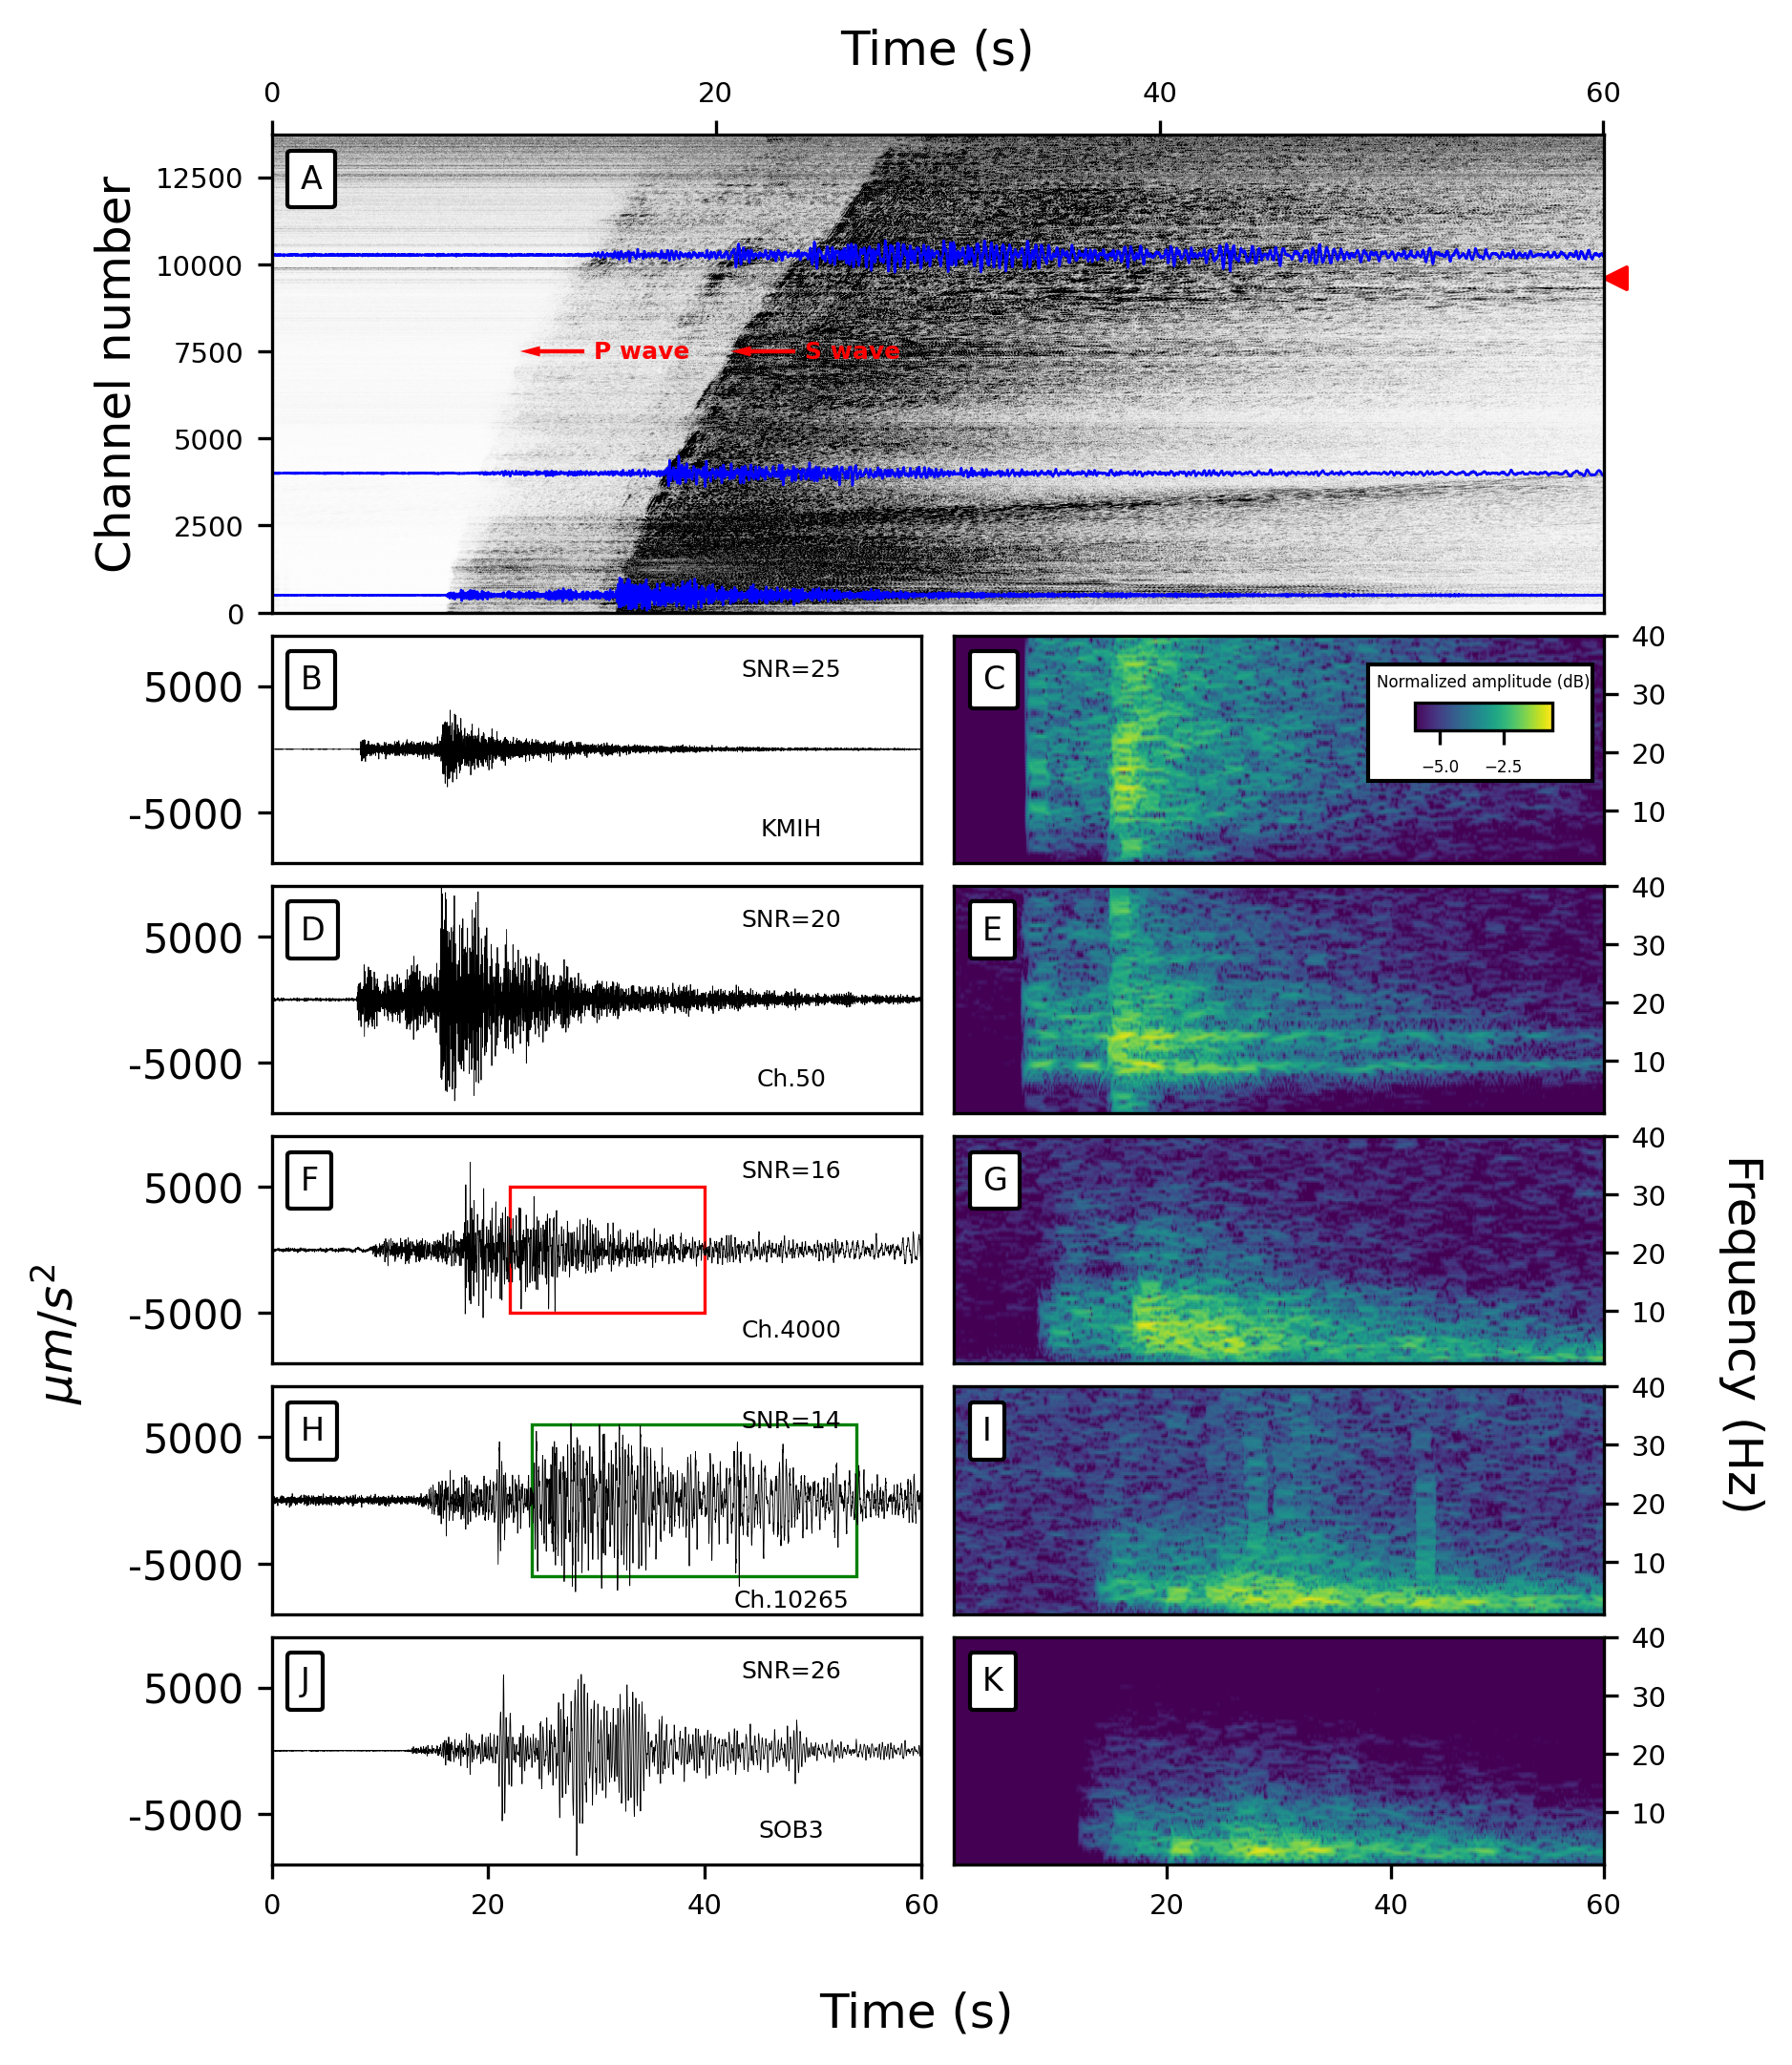

In [18]:
formula2=r'\mu m/s^2'

fig=plt.figure(figsize=(6,8))
fig.dpi=300
fig.subplots_adjust(wspace=0.05, hspace=0.1)

main = plt.subplot2grid(shape=(7,2), loc=(0,0), colspan=2,rowspan=2)

main.imshow(eq,aspect='auto',cmap='Greys',vmin=0,vmax=0.6)

main.set_xlim(0,6000)
main.set_xticks([0,2000,4000,5999])
main.set_xticklabels([0,20,40,60],fontsize=7)
main.set_xlabel('Time (s)', fontsize=12)

main.set_yticks([0,500,1000,1500,2000,2500])
main.set_yticklabels([0,2500,5000,7500,10000,12500],fontsize=7)
main.set_ylim(2744,0)
main.invert_yaxis()
main.set_ylabel('Channel number', fontsize=12)

main.xaxis.tick_top()
main.xaxis.set_label_position('top') 
# main.text(60,2744-190,'A',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),c='k',fontsize=6)

main.plot(np.arange(6000),100+100*normalize(inland_data_filtered),linewidth=0.6,c='blue')
main.plot(np.arange(6000),800+100*normalize(buried_data_filtered),linewidth=0.6,c='blue')
main.plot(np.arange(6000),2053+100*normalize(unburied_data_filtered),linewidth=0.6,c='blue')

at = AnchoredText('A',prop=dict(size=8), frameon=True,loc=2,)
at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
main.add_artist(at)
main.scatter(6055,1920,clip_on = False,marker='<',s=30,color='red')


axs=[]
for i in range(5):
    axl=plt.subplot2grid(shape=(7,2), loc=(2+i,0), colspan=1,rowspan=1)
    axr=plt.subplot2grid(shape=(7,2), loc=(2+i,1), colspan=1,rowspan=1)
    axs.append(axl)
    axs.append(axr)

for ax in axs:
    ax.set_xticks([])
    ax.set_xticklabels([])
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        
for ind in [0,2,4,6,8]:
    axs[ind].set_yticks([-5000,5000])
    axs[ind].set_yticklabels([-5000,5000])
    axs[ind].set_ylim(-9000,9000)
    
for ind in [1,3,5,7,9]:
    axs[ind].set_yticks([])
    axs[ind].set_yticklabels([])
        
    
axs[0].plot(hinet_data_filtered,'k',linewidth=0.2)
axs[0].set_xlim(0,6000)
# axs[0].text(0.02,0.95,'B',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),
#             va='top',ha='left',c='k',fontsize=6,transform=axs[0].transAxes)
axs[0].text(0.8,0.85,'SNR=25',fontsize=6,c='k',va='center',ha='center',transform=axs[0].transAxes)
axs[0].text(0.8,0.15,'KMIH',fontsize=6,c='k',va='center',ha='center',transform=axs[0].transAxes)

f, t, Sxx = signal.spectrogram(normalize(hinet.data), fs=100,nperseg=200,noverlap=195)
mesh=axs[1].pcolormesh(t, f[2:81], np.log10(Sxx)[2:81,:], shading='gouraud',vmin=-6)
# axs[1].text(0.02,0.95,'C',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),
#             va='top',ha='left',c='k',fontsize=6,transform=axs[1].transAxes)
   
axs[2].plot(inland_data_filtered,'k',linewidth=0.2)
axs[2].set_xlim(0,6000)
# axs[2].text(0.02,0.95,'D',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),
#             va='top',ha='left',c='k',fontsize=6,transform=axs[2].transAxes)
axs[2].text(0.8,0.85,'SNR=20',fontsize=6,c='k',va='center',ha='center',transform=axs[2].transAxes)
axs[2].text(0.8,0.15,'Ch.50',fontsize=6,c='k',va='center',ha='center',transform=axs[2].transAxes)

f, t, Sxx = signal.spectrogram(normalize(inland_data), fs=100,nperseg=200,noverlap=195)
axs[3].pcolormesh(t, f[2:81], np.log10(Sxx)[2:81,:], shading='gouraud',vmin=-6)
# axs[3].text(0.02,0.95,'E',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),
#             va='top',ha='left',c='k',fontsize=6,transform=axs[3].transAxes)

 
axs[4].plot(buried_data_filtered,'k',linewidth=0.2)
axs[4].set_xlim(0,6000)
# axs[4].text(0.02,0.95,'F',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),
#             va='top',ha='left',c='k',fontsize=6,transform=axs[4].transAxes)
axs[4].text(0.8,0.85,'SNR=16',fontsize=6,c='k',va='center',ha='center',transform=axs[4].transAxes)
axs[4].text(0.8,0.15,'Ch.4000',fontsize=6,c='k',va='center',ha='center',transform=axs[4].transAxes)

f, t, Sxx = signal.spectrogram(normalize(buried_data), fs=100,nperseg=200,noverlap=195)
axs[5].pcolormesh(t, f[2:81], np.log10(Sxx)[2:81,:], shading='gouraud',vmin=-6)
# axs[5].text(0.02,0.95,'G',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),
#             va='top',ha='left',c='k',fontsize=6,transform=axs[5].transAxes)
  
axs[6].plot(unburied_data_filtered,'k',linewidth=0.2)
axs[6].set_xlim(0,6000)
# axs[6].text(0.02,0.95,'H',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),
#             va='top',ha='left',c='k',fontsize=6,transform=axs[6].transAxes)
axs[6].text(0.8,0.85,'SNR=14',fontsize=6,c='k',va='center',ha='center',transform=axs[6].transAxes)
axs[6].text(0.8,0.06,'Ch.10265',fontsize=6,c='k',va='center',ha='center',transform=axs[6].transAxes)

f, t, Sxx = signal.spectrogram(normalize(unburied_data), fs=100,nperseg=200,noverlap=195)
axs[7].pcolormesh(t, f[2:81], np.log10(Sxx)[2:81,:], shading='gouraud',vmin=-6)
# axs[7].text(0.02,0.95,'I',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),
#             va='top',ha='left',c='k',fontsize=6,transform=axs[7].transAxes)


axs[8].plot(obs_data_filtered,'k',linewidth=0.2)
axs[8].set_xlim(0,6000)
# axs[8].text(0.02,0.95,'J',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),
#             va='top',ha='left',c='k',fontsize=6,transform=axs[8].transAxes)
axs[8].text(0.8,0.85,'SNR=26',fontsize=6,c='k',va='center',ha='center',transform=axs[8].transAxes)
axs[8].text(0.8,0.15,'SOB3',fontsize=6,c='k',va='center',ha='center',transform=axs[8].transAxes)

f, t, Sxx = signal.spectrogram(normalize(obs_data), fs=100,nperseg=200,noverlap=195)
mesh=axs[9].pcolormesh(t, f[2:81], np.log10(Sxx)[2:81,:], shading='gouraud',vmin=-6)
# axs[9].text(0.02,0.95,'K',bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'),
#             va='top',ha='left',c='k',fontsize=6,transform=axs[9].transAxes)

for i in [1,3,5,7,9]:
    axs[i].set_yticks([10,20,30,40])
    axs[i].set_yticklabels([10,20,30,40],fontsize=7)
    axs[i].yaxis.set_ticks_position('right')
    
axs[8].set_xticks([0,2000,4000,6000])
axs[8].set_xticklabels([0,20,40,60],fontsize=7)

axs[9].set_xticks([20,40,59])
axs[9].set_xticklabels([20,40,60],fontsize=7)


fig.text(0.5, 0.06, 'Time (s)',fontsize=12,ha='center', va='center')
fig.text(0.98, 0.357, 'Frequency (Hz)',fontsize=12,rotation=270,ha='center', va='center')
fig.text(0, 0.357, '$%s$' %formula2,fontsize=12,rotation=90,ha='center', va='center')

cax=fig.add_axes([0.79,0.62,0.08,0.012])
cbar=fig.colorbar(mesh, cax=cax,orientation='horizontal')
cbar.set_label('Normalized amplitude (dB)',fontsize=4)
cbar.ax.tick_params(labelsize=4)
cbar.ax.xaxis.set_label_position('top')
rect = patches.Rectangle((38, 15), 20, 20, linewidth=1, edgecolor='black', facecolor='white')
axs[1].add_patch(rect)

nots=['B','C','D','E','F','G','H','I','J','K']
for i in range(len(axs)):
    at = AnchoredText(nots[i],prop=dict(size=8), frameon=True,loc=2,)
    at.patch.set_boxstyle('round',pad=0,rounding_size=0.1)
    axs[i].add_artist(at)
    
# rect = patches.Rectangle((2100,-5000),1800, 10000, linewidth=0.8, edgecolor='red', facecolor='none')
# axs[2].add_patch(rect)
rect = patches.Rectangle((2200,-5000),1800, 10000, linewidth=0.8, edgecolor='red', facecolor='none')
axs[4].add_patch(rect)
rect = patches.Rectangle((2400,-6000),3000, 12000, linewidth=0.8, edgecolor='green', facecolor='none')
axs[6].add_patch(rect)

main.arrow(1400,1500,-200,0,width=1,head_width=30,color='red')
main.text(1450,1500,'P wave',c='r',fontsize=6,va='center',weight='bold')
main.arrow(2350,1500,-200,0,width=1,head_width=30,color='red')
main.text(2400,1500,'S wave',c='r',fontsize=6,va='center',weight='bold')
